##### Import

In [1]:
import os
import sys
import warnings
import gc
from pathlib import Path

import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm import tqdm
import shap

# Filter out warning messages
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Set seaborn style
sns.set_style('whitegrid')

# Add the parent directory to sys.path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Index and deciles for data slicing
idx = pd.IndexSlice

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Test on unseen data

In [2]:
from pathlib import Path
import pandas as pd
import lightgbm as lgb
import pickle
from utils import rank_stocks_and_quantile

def load_model_and_parameters(path):
    with open(path, 'rb') as file:
        loaded_object = pickle.load(file)
    return loaded_object['model'], loaded_object['params']

def read_and_process_data(store_path, key, target_substring):
    with pd.HDFStore(store_path) as store:
        data = store[key]
    data = rank_stocks_and_quantile(data, target_substring=target_substring)
    new_index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
    data.set_index(new_index, inplace=True)
    return data

def filter_by_date(data, look_ahead):
    unique_dates = data.index.get_level_values('date').unique().sort_values()
    assert len(unique_dates) > look_ahead, f"Insufficient unique dates for a look_ahead value of {look_ahead}"
    cut_off_date = unique_dates[look_ahead]
    return data[data.index.get_level_values('date') > cut_off_date]

def synchronize_and_merge_predictions(data, features, model, label):
    y_pred = model.predict(data[features])
    synchronized_labels = data[label][data[label].index.isin(data[features].index)]
    synchronized_y_pred = y_pred[:len(synchronized_labels)]

    preds = synchronized_labels.reset_index(name='actual').assign(predicted=synchronized_y_pred).set_index(['date', 'ticker'])
    cols_to_rename = ['open', 'high', 'low', 'close', 'volume']
    new_col_names = ["FEATURE_" + col for col in cols_to_rename]
    rename_dict = dict(zip(cols_to_rename, new_col_names))
    data_renamed = data.rename(columns=rename_dict)
    preds = preds.reset_index().merge(data_renamed[new_col_names].reset_index(), on=['ticker', 'date'], how='left')
    return preds[['date', 'ticker', 'actual', 'predicted'] + new_col_names].set_index(['ticker', 'date'])

def main_execution(TOP):
    UNSEEN_KEY = '/data/YEAR_20220803_20230803'
    UNSEEN_STORE = Path(f'data/{TOP}_unseen_dataset.h5')
    
    # First, define the MODEL_PATH
    MODEL_PATH = f"/home/sayem/Desktop/Project/models/{TOP}_combined_model_and_params_TARGET_ret_fwd_01d_rank_quantiled.pkl"
    
    # Then, use the MODEL_PATH to load the model and its parameters
    best_model, params = load_model_and_parameters(MODEL_PATH)
    lookahead = params.get('look_ahead', 1)  # Fetching the best look ahead from params

    test_data = read_and_process_data(UNSEEN_STORE, UNSEEN_KEY, 'TARGET_ret_fwd_')
    filtered_test_data = filter_by_date(test_data, lookahead)
    label = f'TARGET_ret_fwd_{lookahead:02d}d_rank_quantiled'
    features = [col for col in test_data.columns if col.startswith('FEATURE_')]
    preds = synchronize_and_merge_predictions(filtered_test_data, features, best_model, label)
    return preds

if __name__ == "__main__":
    top = TOP = 500
    preds = main_execution(TOP)
    print(preds.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 129220 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   actual          129220 non-null  float64
 1   predicted       129220 non-null  float64
 2   FEATURE_open    129220 non-null  float32
 3   FEATURE_high    129220 non-null  float32
 4   FEATURE_low     129220 non-null  float32
 5   FEATURE_close   129220 non-null  float32
 6   FEATURE_volume  129220 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 5.5+ MB
None


In [4]:
from scipy.stats import spearmanr

lr_r, lr_p = spearmanr(preds.actual, preds.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.8%})')

# Return the Information Coefficient and its p-value
information_coefficient = lr_r
p_value = lr_p

# information_coefficient = papermill_information_coefficient, p_value = papermill_p_value
sb.glue("information_coefficient", information_coefficient, display=True)
sb.glue("p_value", p_value, display=True)

Information Coefficient (overall): 3.094% (p-value: 0.00000000%)


0.030940046709680088

9.519909440336237e-29

In [5]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 129220 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   actual          129220 non-null  float64
 1   predicted       129220 non-null  float64
 2   FEATURE_open    129220 non-null  float32
 3   FEATURE_high    129220 non-null  float32
 4   FEATURE_low     129220 non-null  float32
 5   FEATURE_close   129220 non-null  float32
 6   FEATURE_volume  129220 non-null  float64
dtypes: float32(4), float64(3)
memory usage: 5.5+ MB


In [6]:
def add_quantile_signals(df, col_name='predicted', buy_threshold=0.8, sell_threshold=0.1):
    buy_cutoff = df[col_name].quantile(buy_threshold)
    sell_cutoff = df[col_name].quantile(sell_threshold)
    
    # Create a new column for signals
    df['signal'] = 0  # Neutral by default
    df.loc[df[col_name] >= buy_cutoff, 'signal'] = 1  # Buy
    df.loc[df[col_name] <= sell_cutoff, 'signal'] = -1  # Sell
    return df

# Apply the function ## Testing
preds = add_quantile_signals(preds.copy(), buy_threshold=0.95, sell_threshold=0.05)

In [7]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 129220 entries, ('AA', Timestamp('2022-08-05 00:00:00')) to ('ZTS', Timestamp('2023-08-03 00:00:00'))
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   actual          129220 non-null  float64
 1   predicted       129220 non-null  float64
 2   FEATURE_open    129220 non-null  float32
 3   FEATURE_high    129220 non-null  float32
 4   FEATURE_low     129220 non-null  float32
 5   FEATURE_close   129220 non-null  float32
 6   FEATURE_volume  129220 non-null  float64
 7   signal          129220 non-null  int64  
dtypes: float32(4), float64(3), int64(1)
memory usage: 6.4+ MB


##### Backtesting

In [8]:
import pandas as pd
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers
from pypfopt import EfficientFrontier, expected_returns, risk_models
import numpy as np
import yfinance as yf
from IPython.display import clear_output
clear_output()


import quantstats as qs
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
qs.extend_pandas()

# Data Class for Predictions
class PandasPredictions(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('signal', -1),
        ('open', 'FEATURE_open'),
        ('high', 'FEATURE_high'),
        ('low', 'FEATURE_low'),
        ('close', 'FEATURE_close'),
        ('volume', 'FEATURE_volume')
    )

# Function to optimize weights using PyPortfolioOpt
def optimize_weights(datas):
    prices = {}
    for data in datas:
        s = pd.Series(data.close.array, index=data.datetime.array, name=data._name)
        s = s.groupby(s.index).first()  # This will drop duplicate datetime entries, if any
        prices[data._name] = s
    df = pd.concat(prices, axis=1).dropna()

    mu = expected_returns.mean_historical_return(df)
    S_original = risk_models.sample_cov(df)
    S = (1 - 0.05) * S_original + 0.05 * np.eye(S_original.shape[0])
    S += 1e-6 * np.eye(S_original.shape[0])
    
    ef = EfficientFrontier(mu, S, solver="SCS", verbose=False)
    try:
        weights = ef.max_sharpe(risk_free_rate=0.005)
    except ValueError as e:
        if "expected return exceeding the risk-free rate" in str(e):
            print("Using alternative method due to low expected returns.")
            weights = ef.min_volatility()  # or any other method you'd prefer
        else:
            raise e
    # weights = ef.max_sharpe(risk_free_rate=0.005)
    return weights

# Strategy Class
class TradeAndRebalanceStrategy(bt.Strategy):    
    params = {'stop_loss': 0.05, 'take_profit': 0.10, \
        'max_loss': -0.2, 'rebalance_days_interval': 20}
    
    def __init__(self):
        self.rebalance_days = 0
        self.start_cash = self.broker.get_cash()
        self.orders = {}  
        self.atr_dict = {data: btind.ATR(data) for data in self.datas}


    def notify_order(self, order):
        if order.status == order.Completed and order.ref in self.orders:
            del self.orders[order.ref]

    def next(self):        
        for data in self.datas:
            atr_value = self.atr_dict.get(data, 0)[0]
            if data.signal[0] == 1:
                order = self.buy(data)
                self.orders[order.ref] = order
                stop_price = data.close[0] - atr_value * 2
                limit_price = data.close[0] + atr_value * 2
                self.sell(data=data, exectype=bt.Order.Stop, price=stop_price, parent=order.ref)
                self.sell(data=data, exectype=bt.Order.Limit, price=limit_price, parent=order.ref)
            elif data.signal[0] == -1:
                self.sell(data)

        if not self.rebalance_days:
            weights = optimize_weights(self.datas)
            weights = {k: min(v, 0.30) for k, v in weights.items()}
            for data in self.datas:
                self.order_target_percent(data, target=weights.get(data._name, 0))
            self.rebalance_days = self.params.rebalance_days_interval
        else:
            self.rebalance_days -= 1

# Setup
cerebro = bt.Cerebro()
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(btanalyzers.PyFolio, _name='pyfolio')

data_dict = {ticker: preds.xs(ticker) for ticker in \
    preds.index.get_level_values(0).unique()}
for ticker, data_df in data_dict.items():
    data = PandasPredictions(dataname=data_df, name=ticker)
    cerebro.adddata(data)

# # Assuming you want to test max_loss values of -0.1, -0.2, and -0.3
cerebro.optstrategy(TradeAndRebalanceStrategy, 
                    stop_loss=[0.03, 0.05, 0.07], 
                    take_profit=[0.10, 0.12, 0.14],
                    max_loss=[-0.1, -0.2, -0.3],
                    rebalance_days_interval=[10, 20, 30])  # Example range of values

# cerebro.optstrategy(TradeAndRebalanceStrategy, 
#                     stop_loss=[0.03, 0.5 ], 
#                     take_profit=[0.10, 0.12])
#                     # max_loss=[-0.1],
#                     # rebalance_days_interval=[10])  # Example range of values

results = cerebro.run(maxcpus=1) # <= uncomment to run optimization

[*********************100%***********************]  1 of 1 completed

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.



Sharpe Ratio for the strategy: 1.5243119909521368


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


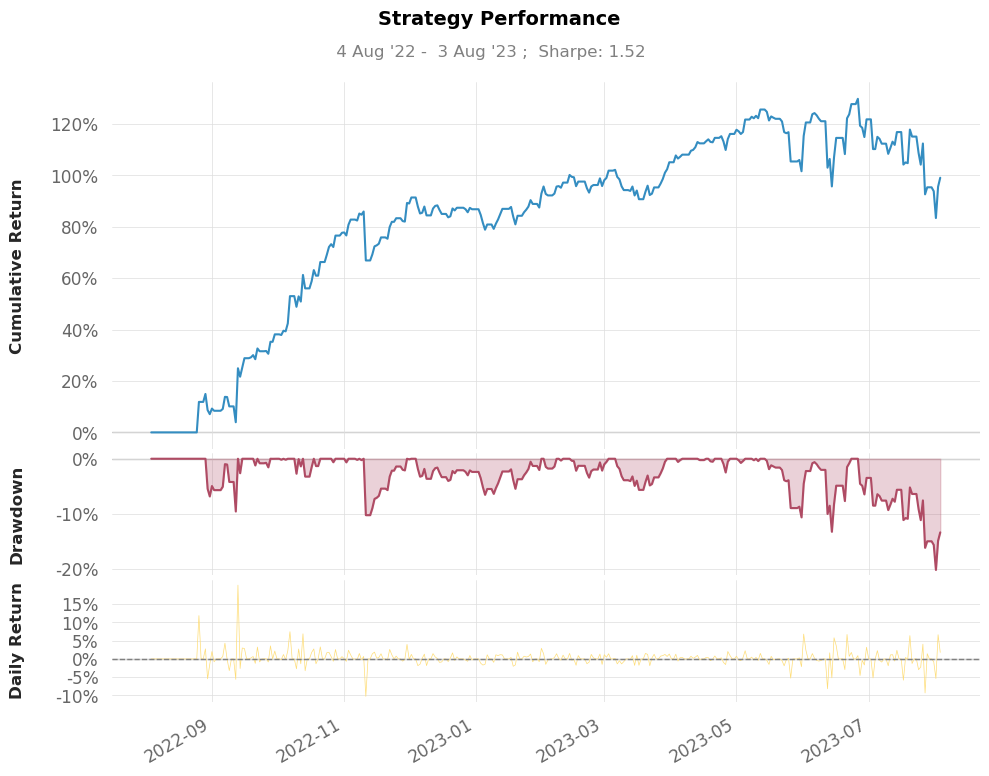

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [9]:
import os
import quantstats as qs
import yfinance as yf
import warnings
import pandas as pd

# Configuration
RISK_FREE_RATE = 0.0  # Annualized risk-free rate
BENCHMARK_TICKER = "SPY"
STRATEGY = "Strategy"
top = TOP  # Placeholder, replace with appropriate value if "TOP" is not the desired string
OUTPUT_REPORT_PATH = f"report/{top}_strategy_report.html"

# Ensure directory exists
directory_path = f'backtest_results/{top}'
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

def calculate_strategy_metrics(results):
    metrics_dict = {}
    best_returns = None
    best_params_str = None
    all_returns = {}

    for res in results:
        for r in res:
            params_str = ', '.join([f"{k}={v}" for k, v in r.params._getitems()])
            returns, _, _, _ = r.analyzers.pyfolio.get_pf_items()
            daily_returns = returns.resample('D').sum()
            all_returns[params_str] = daily_returns

            sharpe_ratio = qs.stats.sharpe(daily_returns, rf=RISK_FREE_RATE)
            drawdown = qs.stats.max_drawdown(daily_returns)
            metrics_dict[params_str] = (sharpe_ratio, drawdown)

            if not best_params_str or (sharpe_ratio > metrics_dict[best_params_str][0]
                                       and drawdown > metrics_dict[best_params_str][1]):
                best_params_str = params_str
                best_returns = daily_returns

    return best_returns, all_returns

def setup_data_for_reporting(best_returns):
    if best_returns.index.tzinfo:
        best_returns.index = best_returns.index.tz_convert('UTC')
    else:
        best_returns.index = best_returns.index.tz_localize('UTC')

    benchmark_data = yf.download(BENCHMARK_TICKER, \
        start=best_returns.index.min(), end=best_returns.index.max())
    benchmark = benchmark_data['Adj Close'].pct_change().dropna()

    best_returns.name = STRATEGY
    benchmark.name = BENCHMARK_TICKER

    benchmark.index = benchmark.index.tz_localize('UTC')
    best_returns.index = best_returns.index.tz_localize(None)
    benchmark.index = benchmark.index.tz_localize(None)

    return best_returns, benchmark

def report_and_visualize_strategy_performance(best_returns, benchmark):
    print("Sharpe Ratio for the strategy:", qs.stats.sharpe(best_returns))
    qs.plots.snapshot(best_returns, title='Strategy Performance', show=True)
    qs.reports.html(best_returns, benchmark=benchmark, \
        title="Strategy Tearsheet", output=OUTPUT_REPORT_PATH)

def main():
    best_returns, all_strategy_returns = calculate_strategy_metrics(results)

    if best_returns is None:
        print("Couldn't extract results for the strategies.")
        return

    df = best_returns, benchmark = setup_data_for_reporting(best_returns)
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
    qs.extend_pandas()
    report_and_visualize_strategy_performance(best_returns, benchmark)

    return best_returns

if __name__ == "__main__":
    best_returns = main()